In [1]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Dataset paths
base_dir = 'augmented_split_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = 256
BATCH_SIZE = 32

# Data generators
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)
val_gen = datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_gen = datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

num_classes = train_gen.num_classes

def build_cnn_model(lr=1e-4, dense_units=128, dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


Found 21421 images belonging to 10 classes.
Found 4586 images belonging to 10 classes.
Found 4602 images belonging to 10 classes.


In [2]:
def fitness_function(params):
    lr, dense_units, dropout_rate = params
    dense_units = int(dense_units)

    model = build_cnn_model(lr=lr, dense_units=dense_units, dropout_rate=dropout_rate)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[early_stop], verbose=0)
    _, val_acc = model.evaluate(val_gen, verbose=0)
    return -val_acc  # Minimize negative accuracy

In [3]:
class AntLionOptimizer:
    def __init__(self, fitness_func, dim, bounds, population_size=6, iterations=10):
        self.fitness_func = fitness_func
        self.dim = dim
        self.bounds = bounds
        self.pop_size = population_size
        self.iterations = iterations

    def initialize_population(self):
        return np.array([np.random.uniform(low, high, self.pop_size) for low, high in self.bounds]).T

    def roulette_wheel_selection(self, fitness):
        inverse = 1.0 / (np.array(fitness) + 1e-8)
        prob = inverse / np.sum(inverse)
        return np.random.choice(range(len(fitness)), p=prob)

    def optimize(self):
        pop = self.initialize_population()
        fitness = [self.fitness_func(ind) for ind in pop]
        elite_idx = np.argmin(fitness)
        elite = pop[elite_idx].copy()
        elite_score = fitness[elite_idx]

        for t in range(self.iterations):
            new_pop = []
            for i in range(self.pop_size):
                selected_idx = self.roulette_wheel_selection(fitness)
                ant = pop[i]
                lion = pop[selected_idx]

                walk = ant + np.random.uniform(-1, 1, self.dim) * (lion - ant)
                walk = np.clip(walk, [b[0] for b in self.bounds], [b[1] for b in self.bounds])
                new_pop.append(walk)

            new_fitness = [self.fitness_func(ind) for ind in new_pop]

            for i in range(self.pop_size):
                if new_fitness[i] < fitness[i]:
                    pop[i] = new_pop[i]
                    fitness[i] = new_fitness[i]
                    if fitness[i] < elite_score:
                        elite = pop[i].copy()
                        elite_score = fitness[i]

            print(f"Iteration {t+1}/{self.iterations} | Best Val Accuracy: {-elite_score:.4f}")

        return elite, -elite_score

In [4]:
# Define bounds
bounds = [
    (1e-5, 1e-3),   # learning rate
    (64, 512),      # dense units
    (0.2, 0.5)      # dropout rate
]

dim = 3
alo = AntLionOptimizer(fitness_function, dim, bounds, population_size=6, iterations=5)
best_params, best_val_acc = alo.optimize()

print("\n✅ Best Parameters Found:")
print("Learning Rate:", best_params[0])
print("Dense Units:", int(best_params[1]))
print("Dropout Rate:", best_params[2])
print("Best Validation Accuracy:", best_val_acc)

2025-06-20 22:52:15.495113: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-06-20 22:52:15.495204: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-06-20 22:52:15.495224: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-06-20 22:52:15.495285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-20 22:52:15.495327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/simarkalsi/Projects/leafClassification/leaf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class shoul

Iteration 1/5 | Best Val Accuracy: 0.8807
Iteration 2/5 | Best Val Accuracy: 0.8807
Iteration 3/5 | Best Val Accuracy: 0.8807
Iteration 4/5 | Best Val Accuracy: 0.9073
Iteration 5/5 | Best Val Accuracy: 0.9073

✅ Best Parameters Found:
Learning Rate: 0.00021035565675915635
Dense Units: 512
Dropout Rate: 0.31671282961167246
Best Validation Accuracy: 0.9073266386985779


Epoch 1/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 70s 101ms/step - accuracy: 0.5617 - loss: 1.2627 - val_accuracy: 0.7109 - val_loss: 0.8451 - learning_rate: 2.1036e-04
Epoch 2/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.7938 - loss: 0.6247 - val_accuracy: 0.7710 - val_loss: 0.6487 - learning_rate: 2.1036e-04
Epoch 3/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 66s 98ms/step - accuracy: 0.8369 - loss: 0.4794 - val_accuracy: 0.8674 - val_loss: 0.4119 - learning_rate: 2.1036e-04
Epoch 4/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.8534 - loss: 0.4259 - val_accuracy: 0.6692 - val_loss: 1.2452 - learning_rate: 2.1036e-04
Epoch 5/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 0.8613 - loss: 0.4099 - val_accuracy: 0.7950 - val_loss: 0.6984 - learning_rate: 2.1036e-04
Epoch 6/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 68s 102ms/step - accuracy: 0.8837 - loss: 0.3408 - val_accuracy: 0.9191 - val_loss: 0.2477 - learning_rate: 1.0518e-04
Epoch 7/25
670/670 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms

/Users/simarkalsi/Projects/leafClassification/leaf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9609 - loss: 0.1401

🎯 Final Test Accuracy after ALO: 96.61%
✅ Model saved as 'ALO_Optimized_Tomato_CNN.keras'


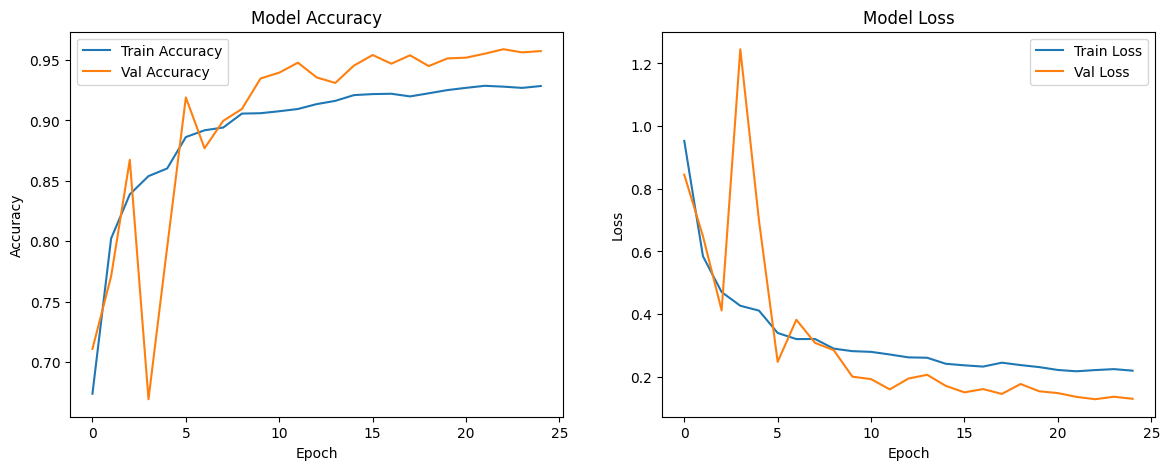


📊 Classification Report:

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.97      0.98      0.97       476
                        Tomato_Early_blight       0.94      0.95      0.94       445
                         Tomato_Late_blight       0.96      0.93      0.94       467
                           Tomato_Leaf_Mold       0.97      0.98      0.98       447
                  Tomato_Septoria_leaf_spot       0.96      0.95      0.95       468
Tomato_Spider_mites_Two_spotted_spider_mite       0.96      0.95      0.95       467
                        Tomato__Target_Spot       0.96      0.95      0.95       461
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.97      0.98      0.98       482
                Tomato__Tomato_mosaic_virus       0.98      1.00      0.99       427
                             Tomato_healthy       0.99      1.00      0.99       462

                                   a

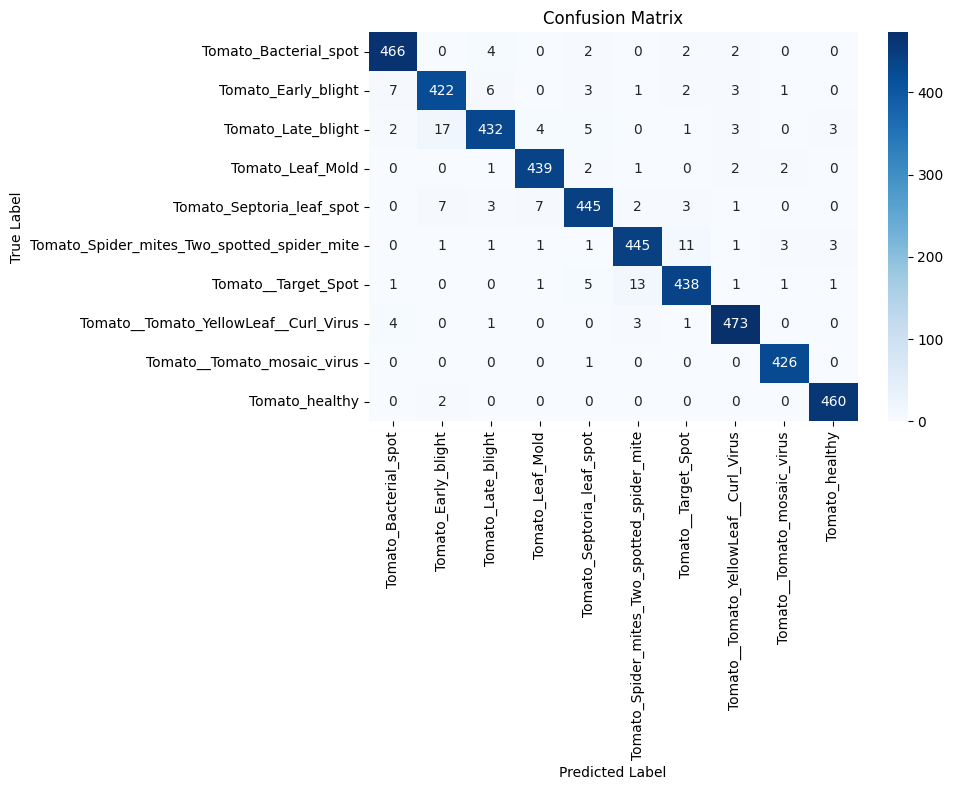

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ⬇️ Use best ALO parameters
best_lr = 0.00021035565675915635
best_dense = 512
best_dropout = 0.31671282961167246

# ⬇️ Rebuild and compile model
final_model = build_cnn_model(
    lr=best_lr,
    dense_units=best_dense,
    dropout_rate=best_dropout
)

# ⬇️ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# ⬇️ Train the model
history = final_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ⬇️ Evaluate on test data
test_loss, test_acc = final_model.evaluate(test_gen, verbose=1)
print(f"\n🎯 Final Test Accuracy after ALO: {test_acc * 100:.2f}%")

# ⬇️ Save model in .keras format
final_model.save("ALO_Optimized_Tomato_CNN.keras")
print("✅ Model saved as 'ALO_Optimized_Tomato_CNN.keras'")

# ⬇️ Plot Accuracy & Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ⬇️ Classification Report
y_true = test_gen.classes
y_pred_probs = final_model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ⬇️ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
